<a href="https://colab.research.google.com/github/gabrielraya/vanilla-diffusion-model/blob/main/Vanilla_Diffusion_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Vanilla Diffusion models 

This notebook provides the minimal code required for you to experience how diffusion models work. 
- It provides the implementation of the Denoising Diffusion Probabilistic Model (DDPM).
- It explains step by step the forward and backward process
- We refer to `GaussianDiffusion` to the diffusion model class using a Gaussian as the diffusion kernel

In [1]:
#@title Preparation
import os 
import sys
IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB: 
    !git clone https://github.com/gabrielraya/vanilla-diffusion-model.git
    if (os.getcwd().split("/")[-1] != 'vanilla-diffusion-model'):
        os.chdir("./vanilla-diffusion-model")
else: 
    os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

Sanity check about running cuda efficiently

In [2]:
import tensorflow as tf
import tensorflow_datasets as tfds
import torch 
import torchvision 


print(tf.__version__)
print(tfds.__version__)
print(torch.__version__)
print(torchvision.__version__)

tf.config.list_physical_devices('GPU')

2.2.0
4.6.0
1.10.2+cu102
0.11.3+cu102


[]

In [3]:
#@title Autoload all modules
%load_ext autoreload
%autoreload 2

import torch
import numpy as np
import plots as plts
from models import ddpm
import matplotlib.pyplot as plt 
import seaborn as sns
import diffusion_lib
from utils import save_checkpoint, restore_checkpoint
import logging
from torch.utils import tensorboard
from tqdm import tqdm
from torchvision.utils import make_grid

from diffusion_lib import GaussianDiffusion
from samplers_lib import progressive_encoding

In [4]:
import torch
import plots as plts
from models import ddpm

# Create directories for experiemental logs
workdir = "./"
results_dir = os.path.join(workdir, "results")
os.makedirs(results_dir, exist_ok=True)
sample_dir = os.path.join(results_dir, "samples")
os.makedirs(sample_dir, exist_ok=True)

tb_dir = os.path.join(results_dir, "tensorboard")
os.makedirs(tb_dir, exist_ok=True)
writer = tensorboard.SummaryWriter(tb_dir)

In [47]:
# @title Training configuration 

batch_size = 64 #@param {"type":"integer"}
n_iters = 10000 #@param {"type":"integer"}
snapshot_freq = 5000 #@param {"type":"integer"}
grid_size = 25 #@param {"type":"integer"}
log_freq = 50
snapshot_freq_for_preemption = 1000

# data
dataset = 'CIFAR10' #@param ['MNIST', 'CIFAR10', 'CIFAR10'] {"type": "string"}
image_size = 32 #@param {"type":"integer"}
random_flip = True #@param {"type":"boolean"}
centered = True  #@param {"type":"boolean"}
uniform_dequantization = False
num_channels = 3

# Model 
scale_by_sigma = False
ema_rate = 0.9999
normalization = 'GroupNorm'
nonlinearity = 'swish'
nf = 128
ch_mult = (1, 2, 2, 2)
num_res_blocks = 2
attn_resolutions = (16,)
resamp_with_conv = True
conditional = True
dropout = 0.1
beta_min = 0.0001
beta_max = 0.02


# Optimizer
weight_decay = 0
optimizer = 'Adam'
lr = 2e-4
beta1 = 0.9
eps = 1e-8
warmup = 5000
grad_clip = 1.



class Config():
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

training = Config(batch_size=batch_size, n_iters=n_iters, log_freq=log_freq, snapshot_freq_for_preemption=snapshot_freq_for_preemption, snapshot_freq=snapshot_freq)
sampling = Config(grid_size=grid_size)
model = Config(ema_rate=ema_rate, normalization=normalization, nonlinearity=nonlinearity,
              nf=nf, ch_mult=ch_mult, num_res_blocks=num_res_blocks, attn_resolutions=attn_resolutions,
               resamp_with_conv=resamp_with_conv, conditional=conditional,
               dropout=dropout, scale_by_sigma=scale_by_sigma, beta_min=beta_min, beta_max=beta_max)

data = Config(dataset=dataset, image_size=image_size, random_flip=random_flip, 
              centered=centered, uniform_dequantization=uniform_dequantization,
              num_channels=num_channels)

optim = Config(weight_decay=weight_decay, optimizer=optimizer, lr=lr, 
              beta1=beta1, eps=eps, warmup=warmup, grad_clip=grad_clip)

config = Config(training=training, sampling=sampling, data=data, model=model, optim=optim)

config.device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

torch.Size([64, 3, 32, 32])


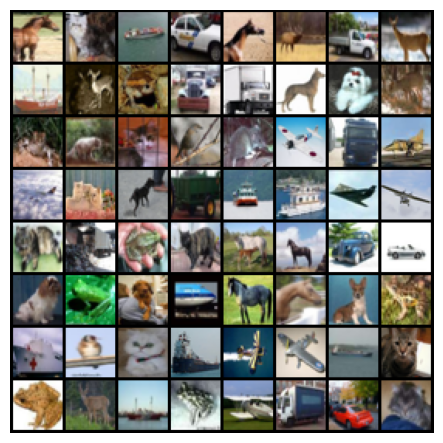

In [6]:
# @title Training configuration 
import datasets

# Build data iterators
train_ds, eval_ds, _ = datasets.get_dataset(config, uniform_dequantization=config.data.uniform_dequantization)
train_iter = iter(train_ds)  # pytype: disable=wrong-arg-types
eval_iter = iter(eval_ds)  # pytype: disable=wrong-arg-types

# Create data normalizer and its inverse
scaler = datasets.get_data_scaler(config)
inverse_scaler = datasets.get_data_inverse_scaler(config)

# Save training samples
batch = torch.from_numpy(next(train_iter)['image']._numpy()).to(config.device).float()
batch = batch.permute(0, 3, 1, 2)
print(batch.shape)
plts.save_image(batch, results_dir, n=64, pos="vertical", name="data_samples", show=True)

## Model

This will load the U-net architecture used for denoising

In [7]:
score_model = ddpm.DDPM(config).to(config.device)
score_model = torch.nn.DataParallel(score_model)

import torch.optim as optim
from models.ema import ExponentialMovingAverage

optimizer = optim.Adam(score_model.parameters(), lr=config.optim.lr, betas=(config.optim.beta1, 0.999), eps=config.optim.eps,
                           weight_decay=config.optim.weight_decay)

ema = ExponentialMovingAverage(score_model.parameters(), decay=config.model.ema_rate)
state = dict(optimizer=optimizer, model=score_model, ema=ema, step=0)

In [8]:
# Create checkpoints directory
checkpoint_dir = os.path.join(results_dir, "checkpoints")
# Intermediate checkpoints to resume training after pre-emption in cloud environments
checkpoint_meta_dir = os.path.join(results_dir, "checkpoints-meta", "checkpoint.pth")
os.makedirs(checkpoint_dir, exist_ok=True)
os.makedirs(os.path.dirname(checkpoint_meta_dir), exist_ok=True)

# Resume training when intermediate checkpoints are detected
state = restore_checkpoint(checkpoint_meta_dir, state, config.device)
initial_step = int(state['step'])

## Diffusion process
**Ingredients**

1. Forward transition distribution 
2. Noise schedule 

In [9]:
# load our diffusion process
diffusion = GaussianDiffusion(config.model.beta_min, config.model.beta_max, T=1000)  # defines the diffusion process

In [10]:
def get_ddpm_loss_fn(diffusion, reduce_mean=True):
    """ Implements DDPM loss """
    
    def loss_fn(model, batch):
        time_steps = torch.randint(0, diffusion.T, (batch.shape[0],), device=batch.device)
        sqrt_alphas_cumprod = diffusion.sqrt_alphas_cumprod.to(batch.device)
        sqrt_1m_alphas_cumprod = diffusion.sqrt_1m_alphas_cumprod.to(batch.device)

        noise = torch.randn_like(batch)
        perturbed_data = sqrt_alphas_cumprod[time_steps, None, None, None] * batch + sqrt_1m_alphas_cumprod[time_steps, None, None, None] * noise


        predicted_noise = score_model(perturbed_data, time_steps)
        losses = torch.square(predicted_noise - noise)
        loss = torch.mean(losses)
        return loss
    return loss_fn

## Visuallizing the forward/corruption process 

The following provides: 
- **progressive encoding**: iterative forward process
- **gifs of this corruption process** 


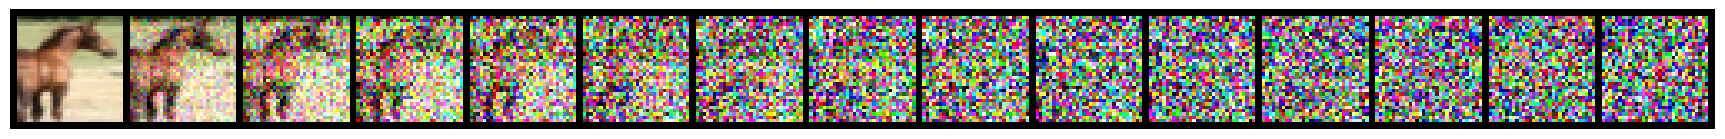

In [11]:
n_samples = 15

# rescale image to [-1,1]
x = scaler(batch)
x_diffused = progressive_encoding(x, diffusion, config, n_samples=n_samples)
plts.save_image(inverse_scaler(x_diffused[0]).clamp(0,1), results_dir, n=n_samples+1, pos="horizontal", name="score_samples", show=True)

In [14]:
import shutil

# proxy to create a gif over a single image
gif_dir = os.path.join(results_dir, "gif")
if os.path.exists(gif_dir) == True: 
    shutil.rmtree(gif_dir)
    
os.makedirs(gif_dir, exist_ok=False)

for t, img in enumerate(inverse_scaler(x_diffused[0]).clamp(0,1)):
    plts.show_image(img, gif_dir, h=2, w=3, name="sample_{:02}".format(t))
    
# create gif of the forward process over single image
plts.draw_gif('samples.gif', gif_dir, '*.png')

![forward_diffusion](./results/gif/samples.gif)

In [15]:
# proxy to create a gif over a single image
gif_grid_dir = os.path.join(results_dir, "gif_grid") 
if os.path.exists(gif_grid_dir) == True: 
    shutil.rmtree(gif_grid_dir)
    
os.makedirs(gif_grid_dir, exist_ok=False)

for t in np.arange(x_diffused.shape[1]):
    plts.save_image(inverse_scaler(x_diffused[:,t]).clamp(0,1), gif_grid_dir, n=64, padding=1, pos="vertical", name="sample_{:02}".format(t))
    
# create gif of the forward process over single image
plts.draw_gif('grid_forward_diffusion.gif', gif_grid_dir, '*.png')

![forward_diffusion](./results/gif_grid/grid_forward_diffusion.gif)

Visualizing a single step

- A single step is almost imperceptible

Clean image


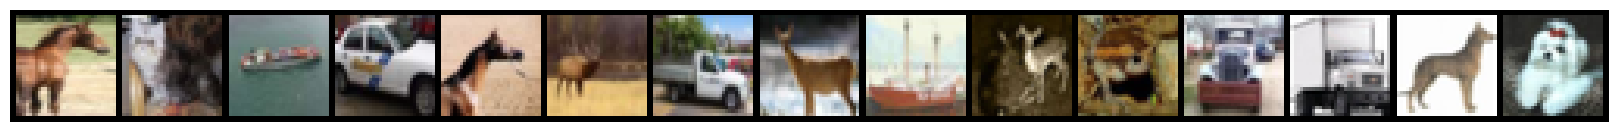

Image perturbed with one step


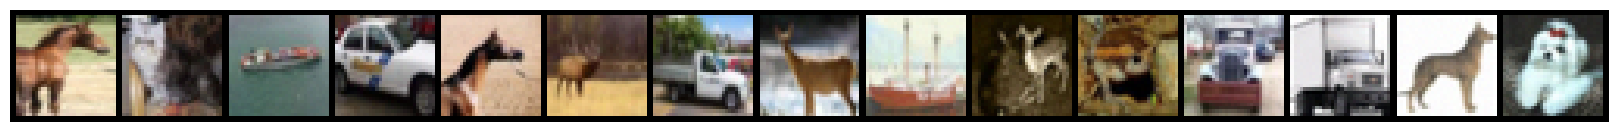

In [34]:
# perturbed data 
t = 0
t = t * torch.ones(batch.shape[0], dtype=int, device=batch.device)
# obtain forward t-step transition distribution
x_t, added_noise = diffusion.forward_step(scaler(batch), t)

print("Clean image")
plts.save_image(batch, results_dir, n=15, pos="horizontal", name="t_", show=True)
print("Image perturbed with one step")
plts.save_image(inverse_scaler(x_t).clamp(0,1), results_dir, n=15, pos="horizontal", name="t_", show=True)

However, after iterative destruction we obtain the following 

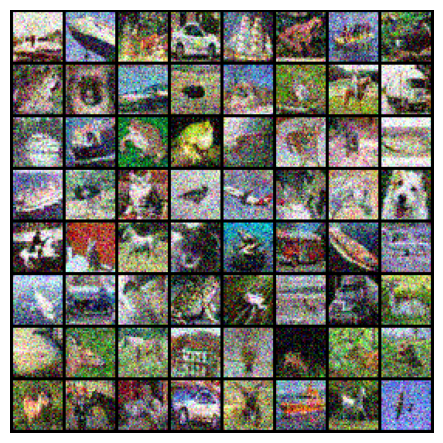

In [17]:
# perturbed data 

for t in range(0, 1000, 100):  
    t = t * torch.ones(batch.shape[0], dtype=int, device=batch.device)
    # obtain forward t-step transition distribution
    mean, std = diffusion.t_step_transition_prob(scaler(batch), t)
    # # by reparameterization we obtain x_t
    z = torch.randn_like(batch)
    x_t = mean + std[:, None, None, None]*z 


    plts.save_image(inverse_scaler(x_t).clamp(0,1), results_dir, n=64, pos="vertical", name="t_", show=True)

## Stochastic encoder

The forward process allows to sample several times 

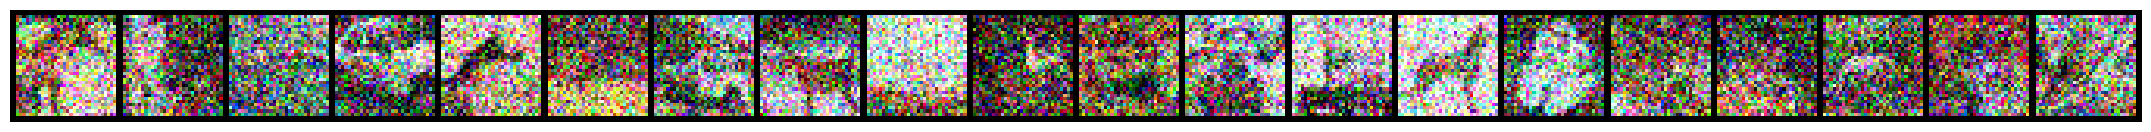

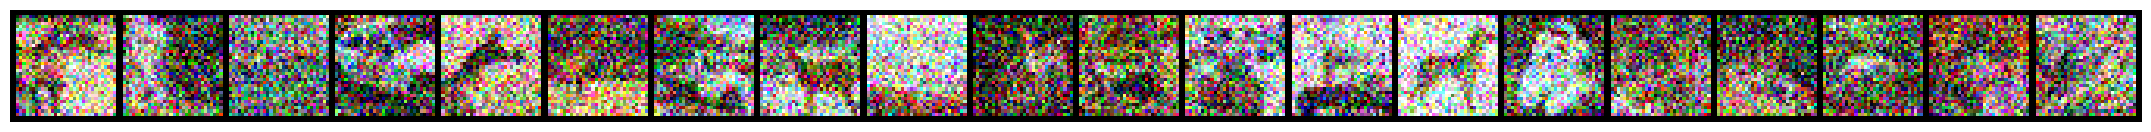

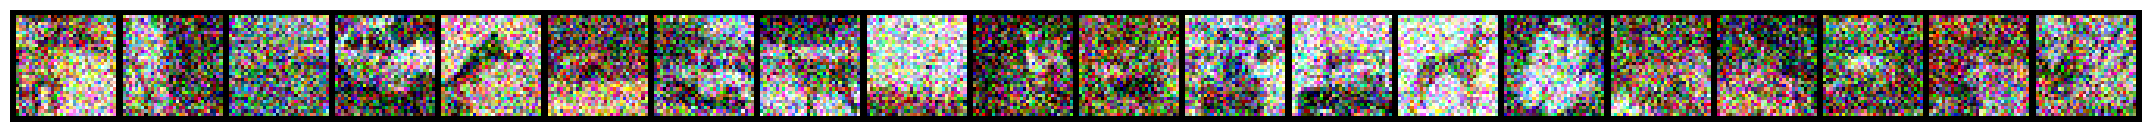

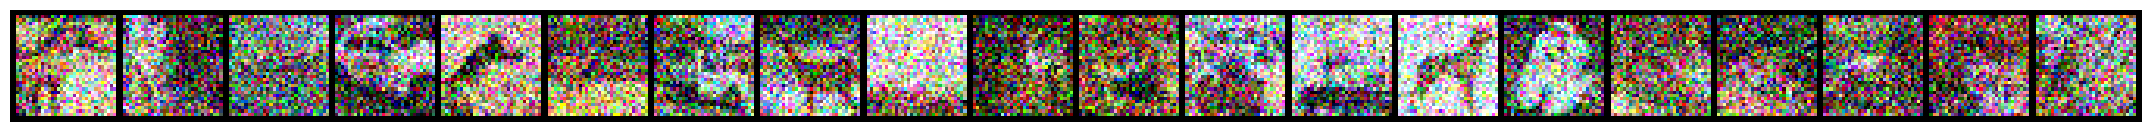

In [40]:
# getting M samples from q(x_t|x_0) at t

t=200
M = 4

# t-step distribution 
t = t * torch.ones(batch.shape[0], dtype=int, device=batch.device)
# obtain forward t-step transition distribution
mean, std = diffusion.t_step_transition_prob(scaler(batch), t)
    
for m in range(M):  
    # by reparameterization we obtain x_t
    z = torch.randn_like(batch)
    x_t = mean + std[:, None, None, None]*z 
    plts.save_image(inverse_scaler(x_t).clamp(0,1), results_dir, n=20, pos="horizontal", name="t_", show=True)

## Noise schedule

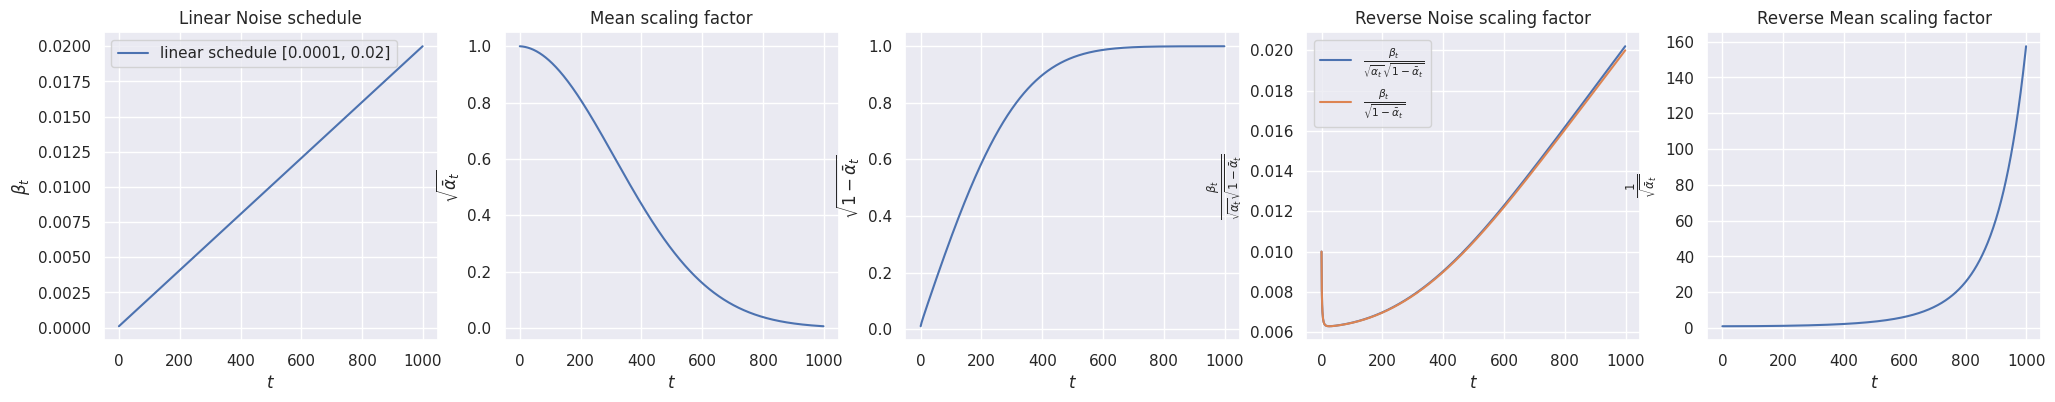

In [41]:
f, ax = plt.subplots(1, 5, figsize=(25, 4)) 
ax[0].plot(diffusion.discrete_betas, label="linear schedule [{}, {}]".format(diffusion.beta_0, diffusion.beta_1))
ax[0].set_xlabel("$t$")
ax[0].set_ylabel(r"$\beta_t$")
ax[0].set_title("Linear Noise schedule")
ax[0].legend() 

ax[1].plot(diffusion.sqrt_alphas_cumprod)
ax[1].set_xlabel("$t$")
ax[1].set_ylabel(r'$\sqrt{\bar{\alpha}_t}$')
ax[1].set_title("Mean scaling factor")


ax[2].plot(diffusion.sqrt_1m_alphas_cumprod)
ax[2].set_ylabel(r'$\sqrt{1-\bar{\alpha}_t}$')
ax[2].set_xlabel(r'$t$') 

ax[3].plot(diffusion.discrete_betas/(torch.sqrt(diffusion.alphas) *diffusion.sqrt_1m_alphas_cumprod), label= r'$\frac{\beta_t}{\sqrt{\alpha_t}\sqrt{1-\bar{\alpha}_t}}$')
ax[3].plot(diffusion.discrete_betas/diffusion.sqrt_1m_alphas_cumprod, label= r'$\frac{\beta_t}{\sqrt{1-\bar{\alpha}_t}}$')
ax[3].set_ylabel(r'$\frac{\beta_t}{\sqrt{\alpha_t}\sqrt{1-\bar{\alpha}_t}}$')
ax[3].set_xlabel(r'$t$')
ax[3].set_title("Reverse Noise scaling factor")
ax[3].legend() 


ax[4].plot(1/diffusion.sqrt_alphas_cumprod)
ax[4].set_xlabel("$t$")
ax[4].set_ylabel(r'$\frac{1}{\sqrt{\bar{\alpha}_t}}$')
ax[4].set_title("Reverse Mean scaling factor")
# # fig.savefig(os.path.join(workdir, "./signal.pdf"), bbox_inches='tight')
plt.show()

## Training 

In [42]:
def multiplots(*arguments, inverse_scaler, n=9, h=9, w=3 ):
     
    f, axis = plt.subplots(1,len(arguments), figsize=(h, w)) 
    
    for i, batch in enumerate(arguments):
        grid = make_grid(inverse_scaler(batch[:n]).clamp(0,1), nrow=int(np.sqrt(n)), padding=1).permute(1, 2, 0).cpu()
        axis[i].imshow(grid); axis[i].axis('off') 

As we can see at the begining the untrained network is not able to predic the added noise

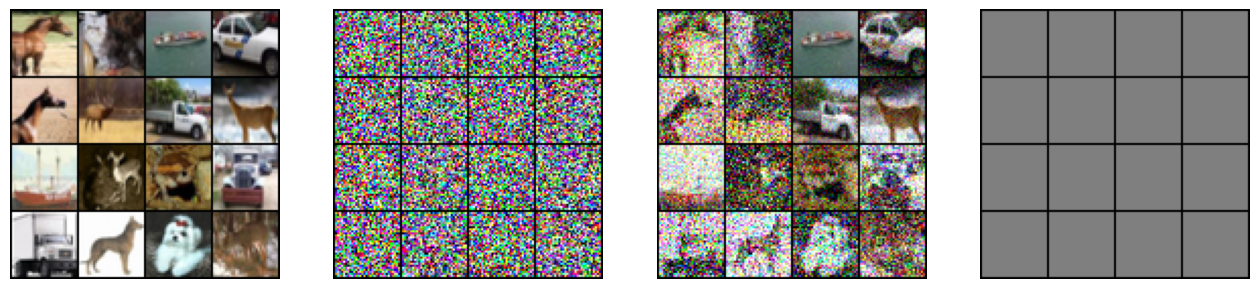

In [43]:
t = torch.randint(0, diffusion.T//4, (batch.shape[0],), device=batch.device)

noise = torch.randn_like(batch)
mean, std = diffusion.t_step_transition_prob(scaler(batch), t)
diffused_data = mean + std[:, None, None, None] * noise
 
if initial_step == 0: 
    predicted_noise = score_model(diffused_data, t)
    multiplots(scaler(batch), noise, diffused_data, predicted_noise, inverse_scaler=inverse_scaler, n=16, h=16,w=16)
else: 
    # create fictitios untrained model 
    model_fake = ddpm.DDPM(config).to(config.device)
    model_fake = torch.nn.DataParallel(model_fake)
    
    predicted_noise = model_fake(diffused_data, t)
    multiplots(scaler(batch), noise, diffused_data, predicted_noise, inverse_scaler=inverse_scaler, n=16, h=16,w=16)

In [48]:
loss_fn = get_ddpm_loss_fn(diffusion, reduce_mean=True)

initial_step

In [49]:
# Train
for step in range(initial_step, config.training.n_iters+1): 
    batch = torch.from_numpy(next(train_iter)['image']._numpy()).to(config.device).float()
    batch = batch.permute(0, 3, 1, 2)
    batch = scaler(batch)
    
    # train step
    model = state['model']
    optimizer = state['optimizer']
    optimizer.zero_grad()
    loss = loss_fn(model, batch)
    loss.backward()
    # optimize_fn(optimizer, model.parameters(), step=state['step'])
    
    if warmup > 0:
      for g in optimizer.param_groups:
        g['lr'] = lr * np.minimum(step / warmup, 1.0)
    if grad_clip >= 0:
      torch.nn.utils.clip_grad_norm_( model.parameters(), max_norm=config.optim.grad_clip)
    optimizer.step()
    
    state['step'] += 1
    state['ema'].update(model.parameters())
    
    
    # evaluation step 
    if step % config.training.log_freq == 0: 
        logging.info("step: %d, training_loss: %.5e" % (step, loss.item()))
        writer.add_scalar("training_loss", loss, step)
        print("step: %d, training_loss: %.5e" % (step, loss.item()))
    
    # Save a temporary checkpoint to resume training after pre-emption periodically
    if step != 0 and step % config.training.snapshot_freq_for_preemption == 0:
        save_checkpoint(checkpoint_meta_dir, state) 
            
    # Save a checkpoint periodically and generate samples if needed
    if step != 0 and step % config.training.snapshot_freq == 0 or step == config.training.n_iters:
        # Save the checkpoint.
        save_step = step // config.training.snapshot_freq
        save_checkpoint(os.path.join(checkpoint_dir, f'checkpoint_{save_step}.pth'), state)

step: 6050, training_loss: 2.27691e-02
step: 6100, training_loss: 4.41067e-02
step: 6150, training_loss: 3.01058e-02
step: 6200, training_loss: 3.47900e-02
step: 6250, training_loss: 2.58424e-02
step: 6300, training_loss: 2.53138e-02
step: 6350, training_loss: 5.04779e-02
step: 6400, training_loss: 2.19756e-02
step: 6450, training_loss: 2.87676e-02
step: 6500, training_loss: 3.78621e-02
step: 6550, training_loss: 4.25751e-02
step: 6600, training_loss: 3.27933e-02
step: 6650, training_loss: 3.24099e-02
step: 6700, training_loss: 3.88815e-02
step: 6750, training_loss: 4.33553e-02
step: 6800, training_loss: 3.32847e-02
step: 6850, training_loss: 3.01309e-02
step: 6900, training_loss: 1.93725e-02
step: 6950, training_loss: 2.58789e-02
step: 7000, training_loss: 3.34534e-02
step: 7050, training_loss: 3.05258e-02
step: 7100, training_loss: 2.89411e-02
step: 7150, training_loss: 1.95539e-02
step: 7200, training_loss: 1.85345e-02
step: 7250, training_loss: 3.31609e-02
step: 7300, training_loss

In [50]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

## Does the noise predictor network actually predicts the right noise? 
Now the network have learn to predict the added noise

$$ x_t = \sqrt{\bar{\alpha_t}}x_0 + \sqrt{(1-\bar{\alpha_t})} * z; z \sim  z~N(0,I)$$

![images][./docs/noise.JPG]


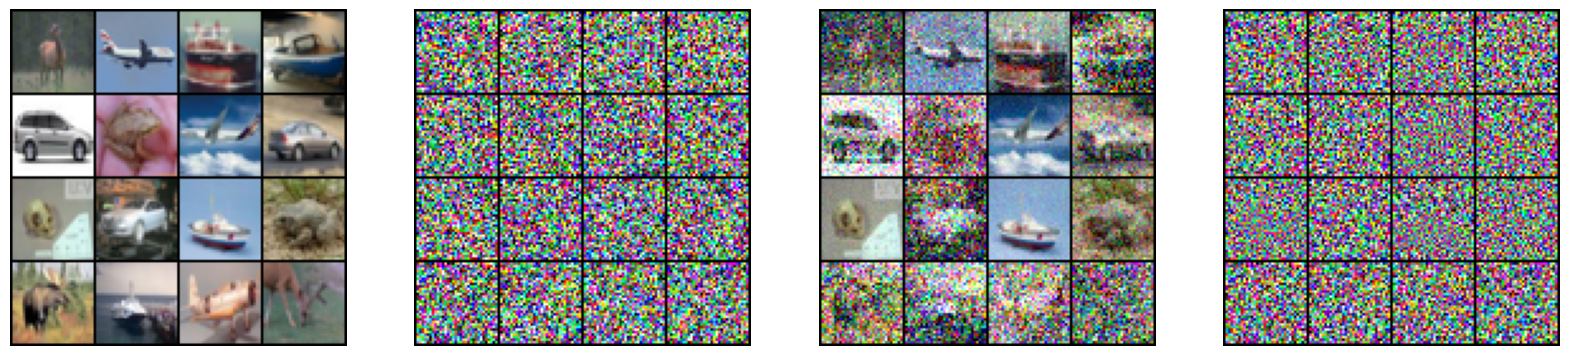

In [105]:
batch = torch.from_numpy(next(train_iter)['image']._numpy()).to(config.device).float()
batch = batch.permute(0, 3, 1, 2)

t = torch.randint(0, diffusion.T//4, (batch.shape[0],), device=batch.device)

noise = torch.randn_like(batch)
mean, std = diffusion.t_step_transition_prob(scaler(batch), t)
diffused_data = mean + std[:, None, None, None] * noise
predicted_noise = score_model(diffused_data, t)

multiplots(scaler(batch), noise, diffused_data, predicted_noise, inverse_scaler=inverse_scaler, n=16, h=20,w=20)

### What if we substract the noise? 

- Substracting the noise with the `fixed` weighting factors provides good denoising in **one step**

$$ x_0 = \frac{1}{ \sqrt{\bar{\alpha_t}}}x_t - \frac{1}{ \sqrt{\bar{\alpha_t}}}\sqrt{(1-\bar{\alpha_t})} * z; z \sim  z~N(0,I)$$


In [106]:
a = 1/diffusion.sqrt_alphas_cumprod[t].to(config.device)
assert torch.all(diffusion.sqrt_1m_alphas_cumprod[t].to(config.device).eq(std))   

Corrupted samples 			 Naive approach  		 Denoise in one step 			 Clean data


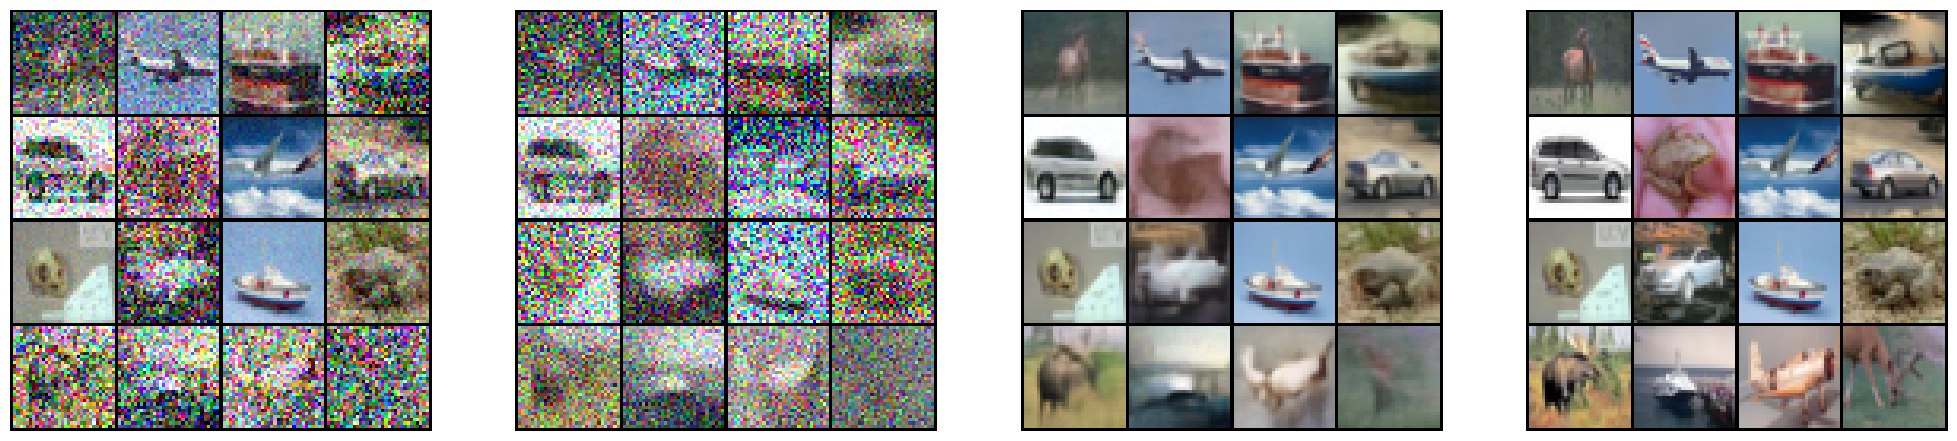

Reconstruction error:  tensor(0.0118, device='cuda:0', grad_fn=<MeanBackward0>)


In [109]:
denoised_data_naive = diffused_data - predicted_noise
denoised_data = a[:, None, None, None]*diffused_data -  (a*std)[:, None, None, None] * predicted_noise

print("Corrupted samples \t\t\t Naive approach  \t\t Denoise in one step \t\t\t Clean data")
multiplots(diffused_data, denoised_data_naive, denoised_data, scaler(batch), inverse_scaler=inverse_scaler, n=16, h=25,w=25)
plt.show()
# reconstruction error
print("Reconstruction error: ", torch.mean((denoised_data- scaler(batch))**2))

0
Corrupted samples 			 Naive approach  		 Denoise in one step 			 Clean data


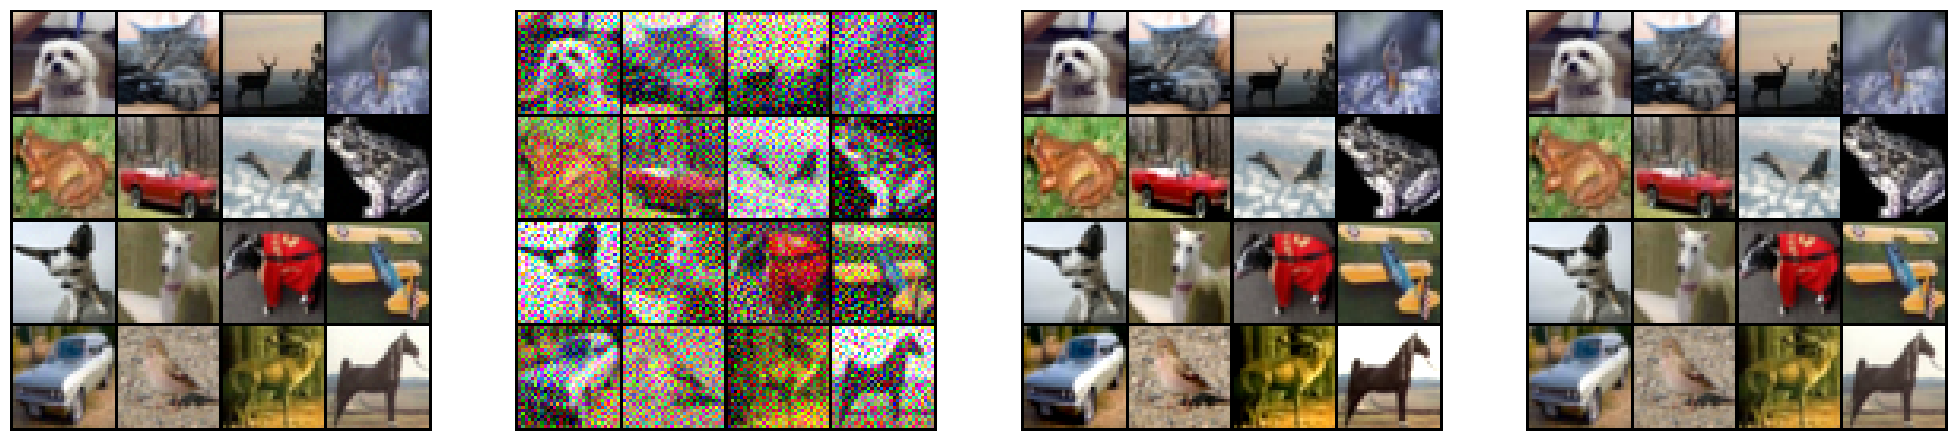

Reconstruction error:  tensor(0.0053, device='cuda:0', grad_fn=<MeanBackward0>)
100
Corrupted samples 			 Naive approach  		 Denoise in one step 			 Clean data


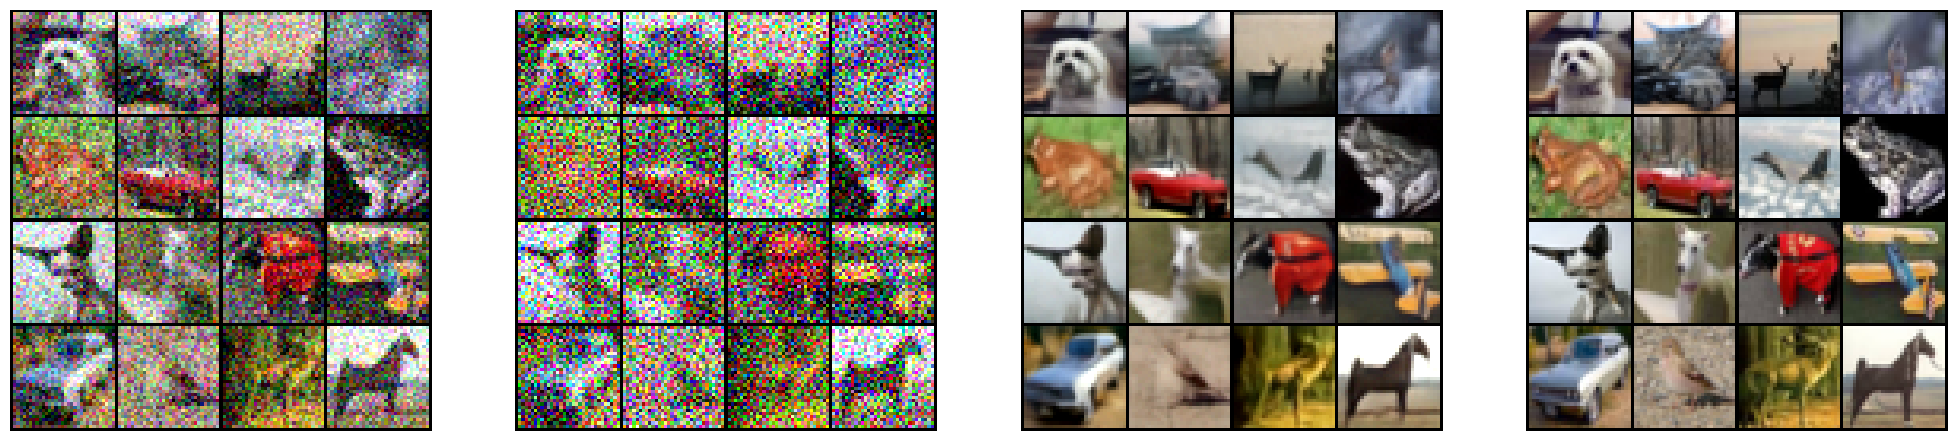

Reconstruction error:  tensor(0.0124, device='cuda:0', grad_fn=<MeanBackward0>)
200
Corrupted samples 			 Naive approach  		 Denoise in one step 			 Clean data


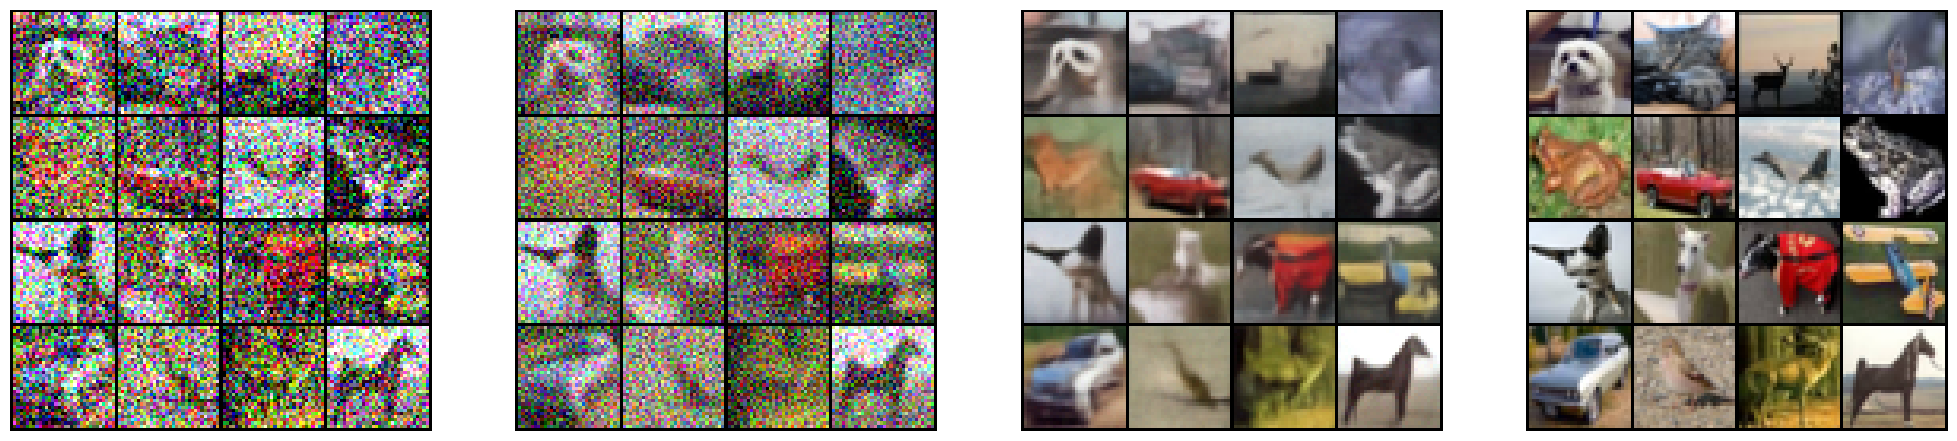

Reconstruction error:  tensor(0.0265, device='cuda:0', grad_fn=<MeanBackward0>)
300
Corrupted samples 			 Naive approach  		 Denoise in one step 			 Clean data


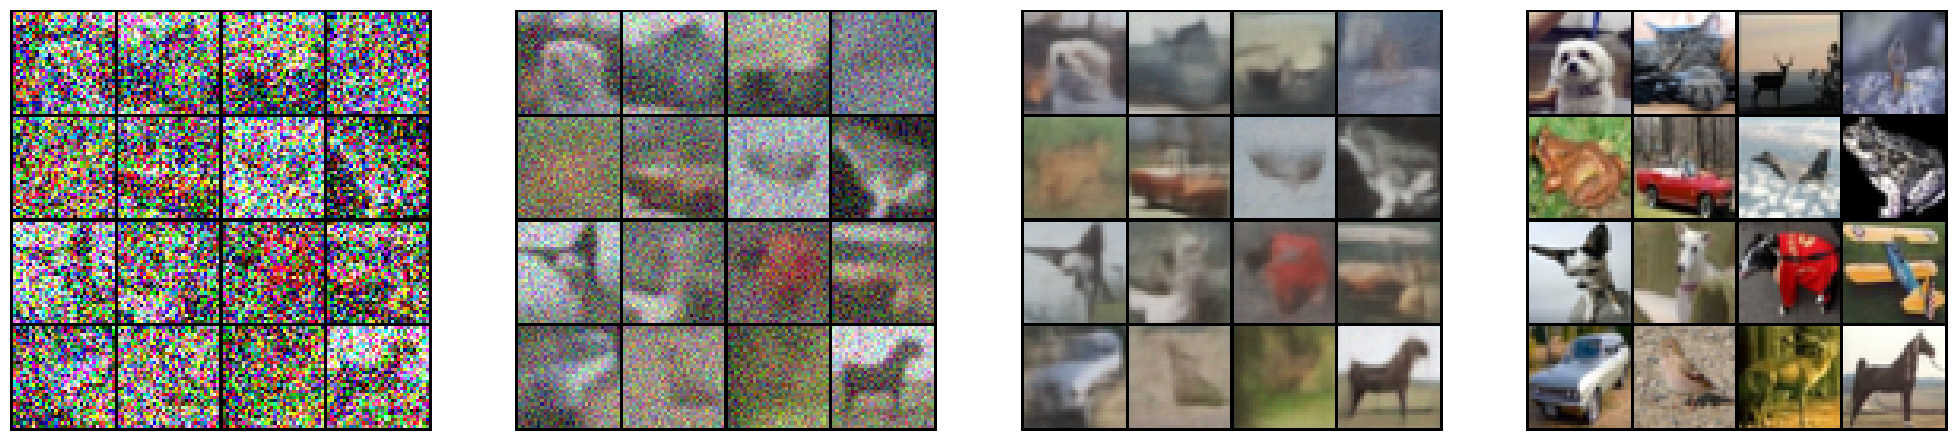

Reconstruction error:  tensor(0.0584, device='cuda:0', grad_fn=<MeanBackward0>)
400
Corrupted samples 			 Naive approach  		 Denoise in one step 			 Clean data


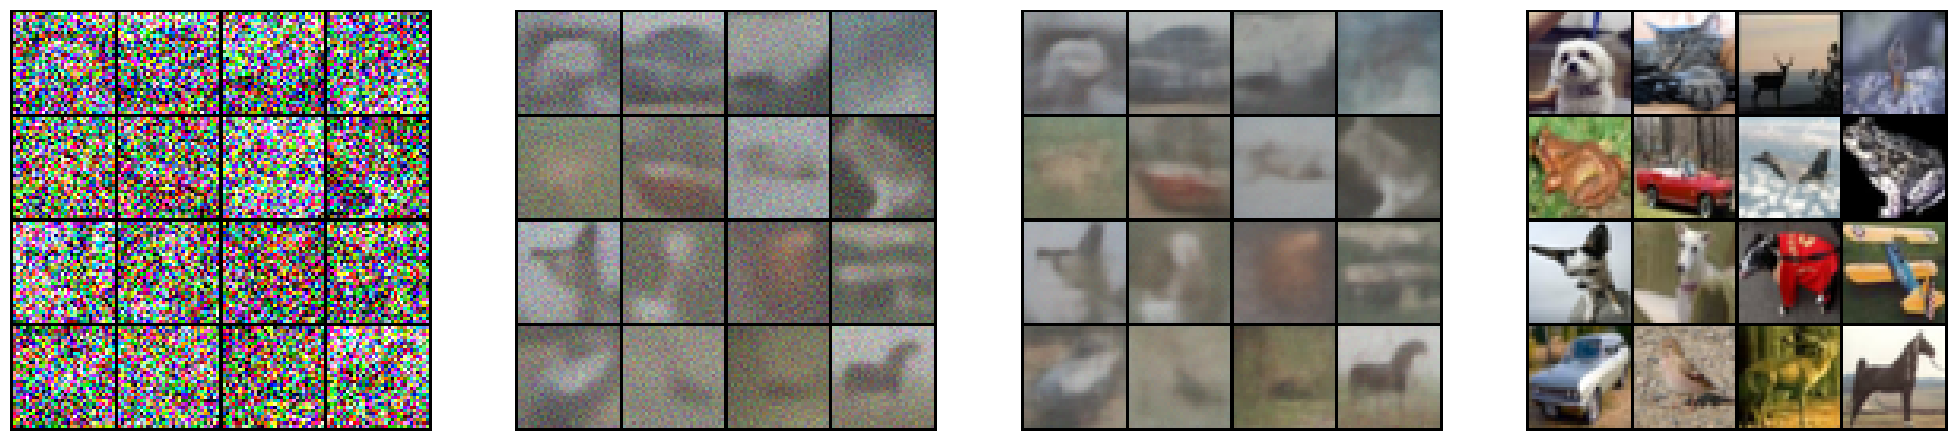

Reconstruction error:  tensor(0.1077, device='cuda:0', grad_fn=<MeanBackward0>)


In [117]:
batch = torch.from_numpy(next(train_iter)['image']._numpy()).to(config.device).float()
batch = batch.permute(0, 3, 1, 2)

for t in range(0, int(diffusion.T//2), 100): 
    print(t)
    t = torch.ones(batch.shape[0], dtype=int, device=batch.device) * t

    noise = torch.randn_like(batch)
    mean, std = diffusion.t_step_transition_prob(scaler(batch), t)
    diffused_data = mean + std[:, None, None, None] * noise
    predicted_noise = score_model(diffused_data, t)

    denoised_data_naive = diffused_data - predicted_noise
    denoised_data = a[:, None, None, None]*diffused_data -  (a*std)[:, None, None, None] * predicted_noise

    print("Corrupted samples \t\t\t Naive approach  \t\t Denoise in one step \t\t\t Clean data")
    multiplots(diffused_data, denoised_data_naive, denoised_data, scaler(batch), inverse_scaler=inverse_scaler, n=16, h=25,w=25)
    plt.show()
    # reconstruction error
    print("Reconstruction error: ", torch.mean((denoised_data- scaler(batch))**2))

**would be ncie to try this out for OOD**

## Sampling

- Recall that the model is train to learn the reverse small updates at each time-step t
- **assumption**: we fixed the variance schedule to be a determined functin (i.e. positive linearly increasing)
- **we are not learning the $\beta_t$**
- Consequently, we only need to learn an approximation of the mean $\tilde{\mu}=\frac{\sqrt{\bar{\alpha}_{t-1}}\beta_t}{1-\bar{\alpha}_t} x_0+ \frac{\sqrt{\alpha_t}(1-\bar{\alpha}_{t-1})}{1-\bar{\alpha}_t}x_t$ forward posterior $q(x_{t-1}|x_t, x_0)$
- Ho. et. al reparameterized this using the fact that we know how to compute $x_t$ to learn a noise predictor network

In [118]:
def denosing_update_fn(x, t, model):
    """ Runs a denoising step following the model perturbation kernel
    Args: 
        x : batch tensor represnting x_t
        t : an N tensor value indicating the time-step t \in [0,T] for the N samples
    Returns: 
        x_{t-1}
    """
    beta = diffusion.discrete_betas.to(t.device)[t.long()]
    alpha = 1. - beta
    std = diffusion.sqrt_1m_alphas_cumprod.to(t.device)[t.long()]

    predicted_noise = model(x, t)
    score = - predicted_noise/ diffusion.sqrt_1m_alphas_cumprod.to(t.device)[t.long()][:, None, None, None]

    x_mean = (x + beta[:, None, None, None] * score) / torch.sqrt(alpha)[:, None, None, None]
    noise = torch.randn_like(x)
    x = x_mean + torch.sqrt(beta)[:, None, None, None] * noise
    return x, x_mean

In [128]:
# reduced size to speed up sampling
shape = batch[:64].shape

with torch.no_grad():
  # sample from the prior distribution
  x = diffusion.prior_sampling(shape).to(config.device)
    
  # reverse time partition [T, 0]
  timesteps =torch.flip(torch.arange(0, diffusion.T, device=config.device), dims=(0,))

  for i in tqdm(range(diffusion.N)):
    t = timesteps[i]
    vec_t = torch.ones(shape[0], device=t.device) * t
    x, x_mean = denosing_update_fn(x, vec_t, model=score_model)

  # return inverse_scaler(x_mean if denoise else x), sde.N * (n_steps + 1)


100%|██████████| 1000/1000 [01:25<00:00, 11.76it/s]


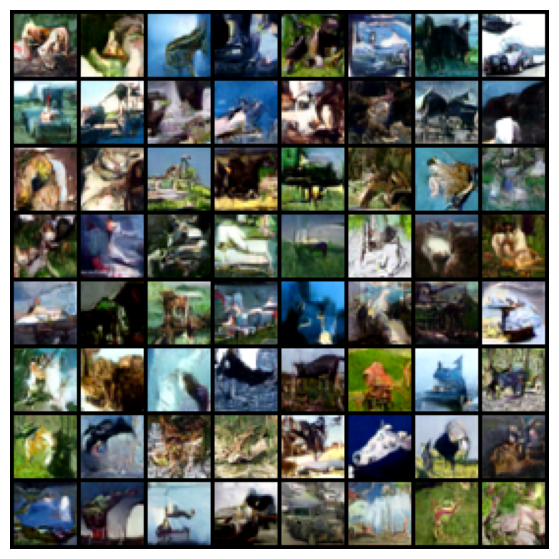

In [127]:
plts.save_image(inverse_scaler(x_mean).clamp(0,1), results_dir, n=64, pos="vertical", w=7, name="t_", show=True)

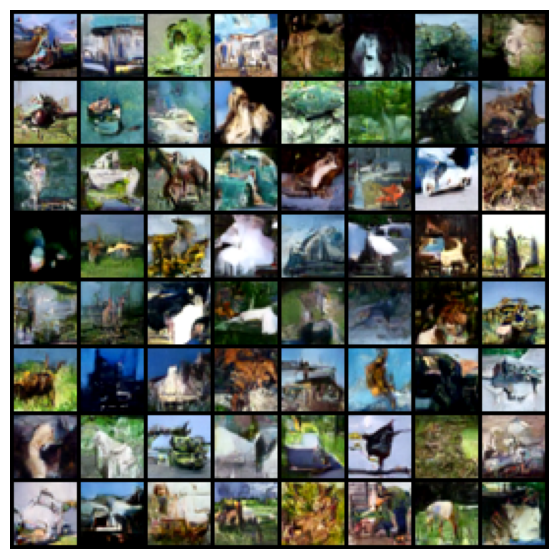

In [129]:
plts.save_image(inverse_scaler(x_mean).clamp(0,1), results_dir, n=64, pos="vertical", w=7, name="t_", show=True)

Obviously, this requires more training, so go ahead and dowload the pretrained model 

**Observations**
